In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import glob
import math
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time

In [73]:
import pandas as pd
pd.read_csv('DatosFinales.csv')

,Unnamed: 0,Fecha,Hora,Potencia [kW],Irradiacion [W/m2],Temperatura de modulos[C]
0,0,1/10/2019,7:00,4.37,57.08,15.13
1,1,1/10/2019,7:05,5.71,73.87,15.49
2,2,1/10/2019,7:10,7.76,101.24,16.13
3,3,1/10/2019,7:15,11.23,144.43,17.19
4,4,1/10/2019,7:20,14.76,198.53,18.62
...,...,...,...,...,...,...
54955,54955,31/12/2020,16:35,0.10,8.75,14.15
54956,54956,31/12/2020,16:40,0.05,7.03,14.15
54957,54957,31/12/2020,16:45,0.10,8.97,14.20
54958,54958,31/12/2020,16:50,0.18,11.11,14.19


In [83]:
abril = pd.read_csv('DatosFinales.csv').drop('Unnamed: 0',axis = 1)
#abril = abril[['Fecha','Hora','Energia [kWh]','Irradiacion [Wh/m2]','Temperatura de modulos [C]']]
abril = abril[['Fecha','Hora','Potencia [kW]','Irradiacion [W/m2]','Temperatura de modulos[C]']]
abril['Time'] = pd.to_datetime(abril['Fecha']+' '+abril['Hora'])
abril = abril.set_index('Time')
abril = abril. resample('20T').mean()
abril.dropna(inplace = True)
abril.set_index(np.array(range(13740)),inplace = True)

<AxesSubplot:>

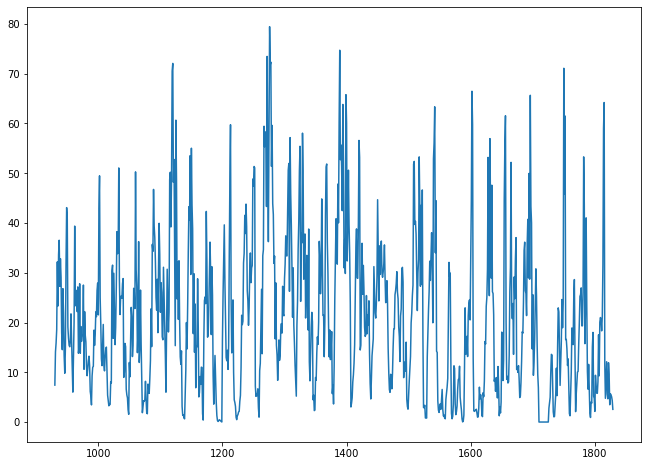

In [84]:
#abril['Energia [kWh]'][930:1830].plot(figsize = (11,8))
abril['Potencia [kW]'][930:1830].plot(figsize = (11,8))

### Función de auto correlación y de autocorrelación parcial

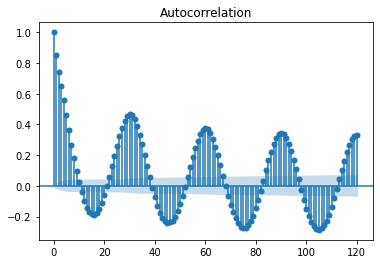

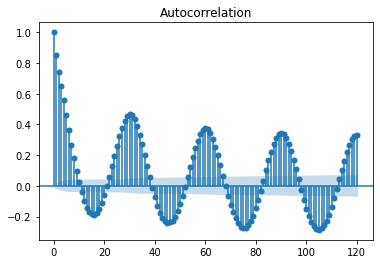

In [85]:
#plot_acf(abril['Energia [kWh]'], lags =120)
plot_acf(abril['Potencia [kW]'], lags =120)


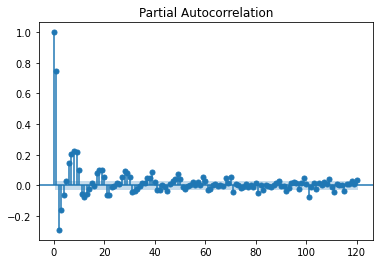

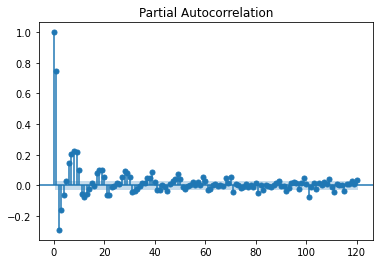

In [18]:
plot_pacf(abril['Energia [kWh]'], lags =120)

### Se observa que los datos a tratar son no estacionarios, se procede a realizar la conversión a datos estacionarios

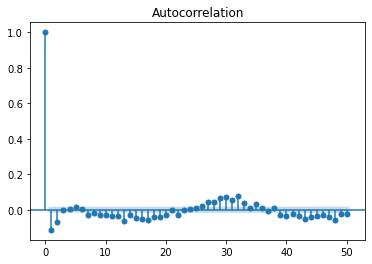

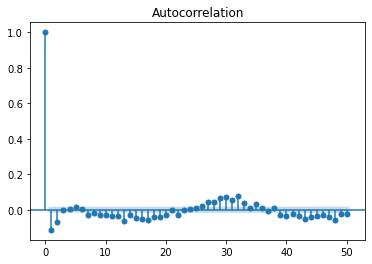

In [86]:
k=1
first_diff = abril['Potencia [kW]'].diff(k)
plot_acf(first_diff[k:], lags = 50)

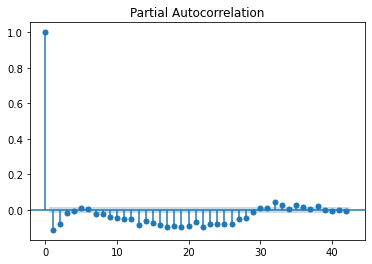

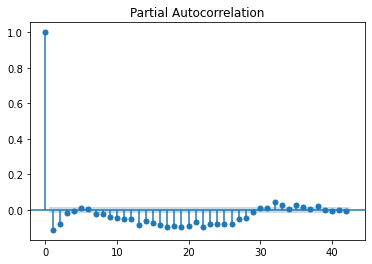

In [87]:
plot_pacf(first_diff[1:])

## Entrenamiento del modelo SARIMAX

#### Datos de entrenamiento y de prueba

In [111]:
train_data = abril['Potencia [kW]'][930:1830]
test_data = abril['Potencia [kW]'][1830:2160]

In [112]:
train_data = train_data.values
test_data = test_data.values

#### Pruebas 

Se realiza el ajuste de diferentes modelos fijando un valor para el parámetro SAR y SMA y realizando la prueba de estos con diferentes valores de AR y MA.

In [113]:
my_order = (2,1,1)
my_seasonal_order = (1, 1, 1, 30)

model = SARIMAX(train_data/np.max(train_data), order = my_order, seasonal_order=my_seasonal_order)

In [114]:
# Ajuste del modelo
start = time()
model_fit = model.fit(disp = True, verbose = True)
end = time()
print('Tiempo de ajuste del modelo: ',end-start)

Tiempo de ajuste del modelo:  17.545584440231323


In [115]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  900
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 30)   Log Likelihood                 565.705
Date:                            Fri, 05 Feb 2021   AIC                          -1119.411
Time:                                    23:26:50   BIC                          -1090.807
Sample:                                         0   HQIC                         -1108.465
                                            - 900                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6546      0.029     22.714      0.000       0.598       0.711
ar.L2          0.0185      0.029   

In [116]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
#predictions = pd.Series(predictions, index=test_data.index)

In [117]:
predictions= predictions*np.max(train_data)
predictions

array([ 7.69664855, 10.69404948, 13.19376244, 14.41292082, 17.95496403,
       21.31320966, 22.50051366, 23.21797655, 24.20064341, 25.33971298,
       30.33826707, 28.16386055, 29.47487347, 24.20988919, 20.14869912,
       19.99990869, 20.31317702, 19.00422248, 18.05020716, 17.36926292,
       17.5312451 , 11.92655712, 11.09247468,  8.35774707,  7.62055765,
        6.00674972,  6.03278082,  2.49168651, -0.34910345, -2.30333557,
        4.15377285,  8.31519775, 11.36338299, 12.96656921, 16.71467821,
       20.26105053, 21.87184809, 22.39506203, 23.7724662 , 24.95261179,
       29.79958747, 27.64938789, 29.03103446, 24.2954822 , 21.28064636,
       21.31390574, 19.87746577, 18.38679898, 17.58330888, 17.0522206 ,
       16.99340563, 11.54427231, 10.97856881,  8.25747717,  7.34198649,
        5.85491045,  5.87252851,  2.43623261, -0.3346614 , -2.28334593,
        4.13035285,  8.2532157 , 11.28323323, 12.87369871, 16.61498259,
       20.15512317, 21.75188888, 22.28154073, 23.64586513, 24.82

In [118]:
rmse=math.sqrt(mean_squared_error(test_data,predictions*np.max(train_data)))
rmse

1340.9728290272212

Text(0, 0.5, 'Error')

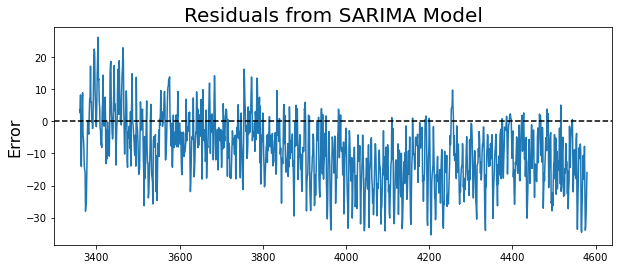

In [69]:
residuals = test_data - predictions
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

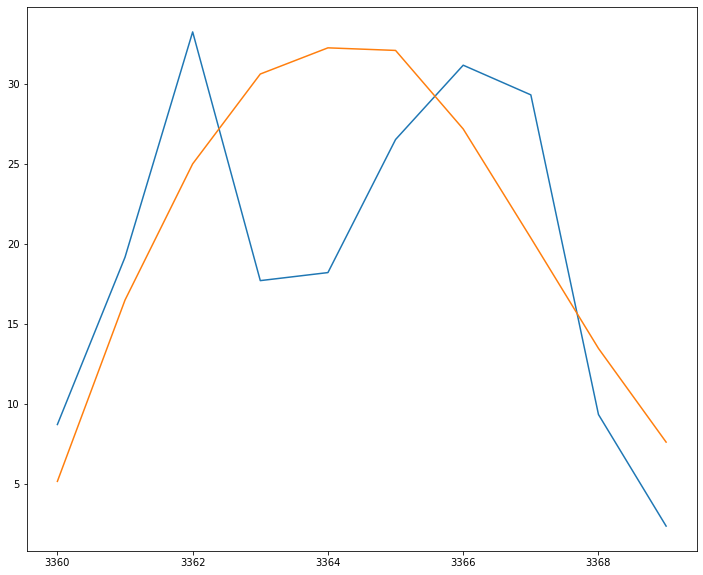

In [70]:
plt.figure(figsize = (12,10))
plt.plot(test_data[0:10])
plt.plot(predictions[0:10])